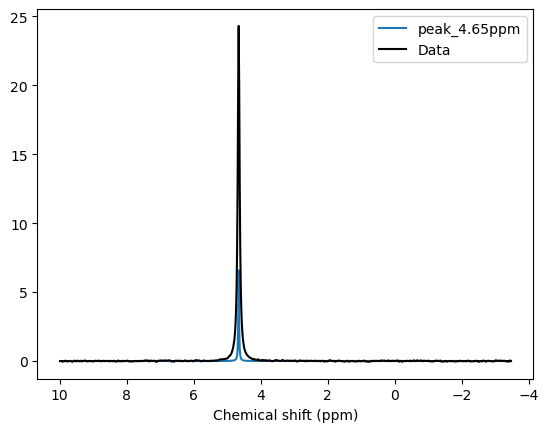

In [288]:
from scipy.linalg import circulant
import numpy as np
import matplotlib.pyplot as plt

from fsl_mrs.utils.misc import FIDToSpec
from fsl_mrs.utils.synthetic.synthetic import syntheticFID
from fsl_mrs.core import MRS, basis
from fsl_mrs.utils.preproc import apodize

npoints = 1024
noise_sd = np.sqrt(0.01)
noise_sd_single_channel = noise_sd / np.sqrt(2)
bandwidth = 2000

def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = FIDToSpec(window ** 2) * noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))

chemical_shifts = np.asarray([4.65,]) - 4.65
basis_fid_array = []
for shift in chemical_shifts:
    FID, header = syntheticFID(
        noisecovariance=[[0]],
        chemicalshift=[shift,],
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[3,]
    )
    basis_fid_array.append(FID[0])
    header['fwhm'] = 1.0


spec_basis = basis.Basis(
    np.stack(basis_fid_array),
    [f'peak_{x+4.65}ppm' for x in chemical_shifts],
    [header, ] * len(chemical_shifts))


FIDs, header = syntheticFID(
    noisecovariance=[[noise_sd_single_channel**2]],
    chemicalshift=chemical_shifts,
    points=npoints,
    bandwidth=bandwidth,
    linewidth=[5, 5],
    amplitude=[10, 10]
)

def apod_window(size: int, dwelltime: float, broadening: float) -> np.ndarray:
    taxis = np.linspace(0, dwelltime * (size - 1), size)
    Tl = 1 / broadening
    return np.exp(-taxis / Tl)

def apodise_w(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window * data, window

FID, wind = apodise_w(
    FIDs[0],
    1 / bandwidth,
    10)

dir_cov = make_windowed_cov(
    wind,
    noise_sd)

example_mrs = MRS(FID=FID, header=header, basis=spec_basis)

_ = example_mrs.plot_basis(add_spec=True, ppmlim=(-10,10))

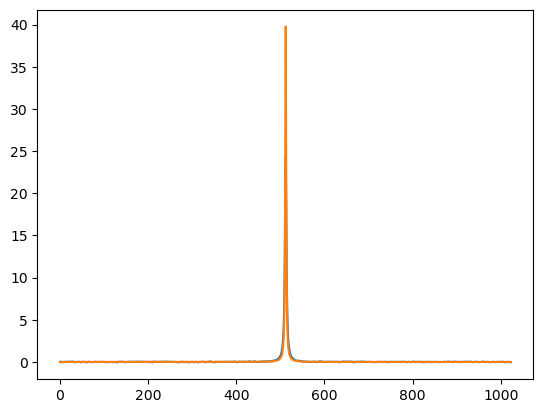

6.72333311246831e-07
4.1131021694498345e-07
5.988062935911416e-07


In [293]:
def forward_and_jac(x):
    # x is conc_1, conc_2, eps, gamma
    
    exp = np.exp(-(1j * x[1] + x[2]) * header['taxis'])
    m_term = exp * spec_basis.original_basis_array.T
    Fmet = FIDToSpec(m_term, axis=1).T
    Ftmet = FIDToSpec(header['taxis'] * m_term, axis=1).T
    Ftmetc = Ftmet @ x[:1, np.newaxis]
    S = Fmet @ x[:1, np.newaxis]

    # Gradients
    dSdc = Fmet
    dSdgamma = -Ftmetc
    dSdeps = -1j * Ftmetc
    jac = np.concatenate((dSdc, dSdeps, dSdgamma), axis=1)

    return S, jac


gt = np.asarray([10, 0, (5-3)*np.pi])
S1, jac = forward_and_jac(gt)

plt.plot(FIDToSpec(FID).real)
plt.plot(S1.real)
plt.show()
eps = 1E-08

for idx in range(3):
    tmp = gt.copy()
    tmp[idx] += eps
    S2, _ = forward_and_jac(tmp)
    manual_grad = (S2[:,0] - S1[:,0]) / eps
    print(np.max(np.abs(manual_grad-jac[:, idx])))
    assert np.allclose(manual_grad, jac[:, idx], atol=1E-5)


[  0.01873956   0.01486546 -11.93335758]


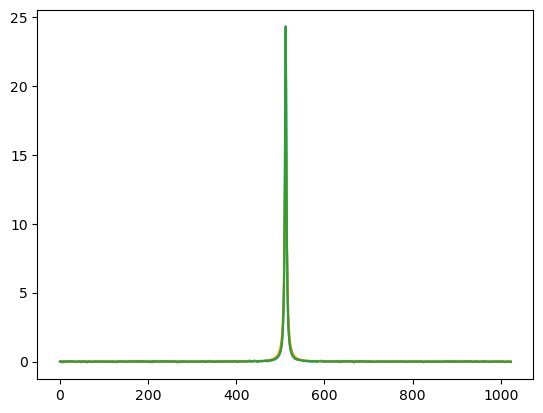

In [295]:
from scipy.optimize import minimize
def fit(fid, x0):
    spec_data = FIDToSpec(fid)
    def err_lsq(x):
        err = spec_data[:, np.newaxis] - forward_and_jac(x)[0]
        return np.real(np.sum(err * np.conj(err)))


    def grad_lsq(x):
        S, dS = forward_and_jac(x)
        Spec = spec_data[: , np.newaxis]
        return np.real(np.sum(S * np.conj(dS) + np.conj(S) * dS - np.conj(Spec) * dS - Spec * np.conj(dS), axis=0))

    xout = minimize(
        err_lsq,
        bounds=((0, None), (None, None), (0, None)),
        x0=x0,
        jac=grad_lsq
    )
    return xout.x
gt = np.asarray([10, 0, (12-3)*np.pi])

xout = fit(FID, gt)

print(xout- gt)
plt.plot(FIDToSpec(FID).real)
plt.plot(forward_and_jac(gt)[0].real)
plt.plot(forward_and_jac(xout)[0].real)
plt.show()


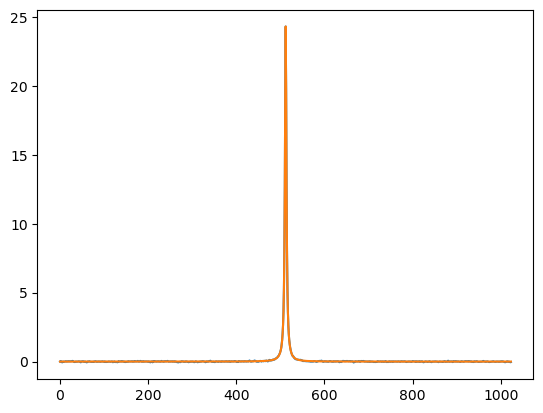

In [297]:
import numpy as np
import scipy.linalg as sla
import scipy.optimize as opt

def fit_nonlinear_complex_with_bounds(
        data: np.ndarray,
        model: callable,
        theta0: np.ndarray,
        C: np.ndarray,
        jac: callable = None,
        bounds=None,
        minimize_options: dict = None,
        method=None,
        verbose=False):
    """
    Fit nonlinear complex model m(theta) to complex data d with known covariance C,
    using scipy.optimize.minimize and supporting parameter bounds.

    Parameters
    ----------
    d : array_like, shape (N,)
        Complex data vector.
    model : callable
        model(theta) -> m (complex vector of shape (N,))
    theta0 : array_like, shape (M,)
        Initial parameter vector (real).
    C : array_like, shape (N, N)
        Known Hermitian positive-definite covariance matrix.
    jac : callable, optional
        jac(theta) -> J with shape (N, M) (complex). If given, analytic gradient is used.
    bounds : sequence or None
        Sequence of (min, max) pairs for each element in theta, or None. Matches scipy.optimize.minimize format.
    minimize_options : dict, optional
        Options passed to scipy.optimize.minimize.
    return_cov : bool
        If True, attempt to compute covariance ~ inv(J^H C^{-1} J) at solution.
    method : str or None
        Minimizer method. If None, defaults to 'L-BFGS-B' if bounds provided, else 'BFGS'.

    Returns
    -------
    Optimised theta
    """
    N = data.shape[0]
    if C.shape != (N, N):
        raise ValueError("C must be square with shape (N,N) matching data length N.")

    # choose default method
    if method is None:
        method = 'L-BFGS-B' if bounds is not None else 'BFGS'

    # Cholesky and solver
    L = sla.cholesky(C, lower=True, check_finite=False)
    cfact = sla.cho_factor(C, lower=True, check_finite=False)
    def solve_C(rhs):
        return sla.cho_solve(cfact, rhs, check_finite=False)
    def whiten(v):
        return sla.solve(L, v)

    # validate bounds shape
    if bounds is not None:
        if len(bounds) != theta0.size:
            raise ValueError("bounds must be length M = len(theta0).")

    # Objective
    def objective(theta):
        y = whiten(data - model(theta))
        return np.real(np.vdot(y, y))

    # Analytic gradient if provided
    jac_for_minimize = None
    if jac is not None:
        def grad(theta):
            m = model(theta)
            J = jac(theta)
            if J.shape != (N, theta.size):
                raise ValueError("jac(theta) must return shape (N, M).")
            Cinv_resid = solve_C(data - m)
            g_complex = -2.0 * (J.conj().T @ Cinv_resid)
            return np.real(g_complex)
        jac_for_minimize = grad

    if minimize_options is None:
        minimize_options = {}

    # call minimize with bounds
    opt_result = opt.minimize(fun=objective,
                              x0=theta0,
                              jac=jac_for_minimize,
                              method=method,
                              bounds=bounds,
                              options=minimize_options)
    if verbose:
        print(opt_result)
    
    return opt_result.x

def fwd(x):
    return forward_and_jac(x)[0][:,0]

def jac(x):
    return forward_and_jac(x)[1]

out = fit_nonlinear_complex_with_bounds(
    FIDToSpec(FID),
    fwd,
    gt,
    dir_cov,
    jac=jac,
    bounds=((0, None), (None, None), (0, None))
)
plt.plot(FIDToSpec(FID).real)
# plt.plot(forward_and_jac(gt)[0].real)
plt.plot(forward_and_jac(out)[0].real)
plt.show()


In [300]:
%%timeit
fit_nonlinear_complex_with_bounds(
    FIDToSpec(FID),
    fwd,
    np.asarray([10, 0, 16]),
    dir_cov,
    jac=jac,
    bounds=((0, None), (None, None), (0, None)),
    verbose=False
)

102 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [302]:
%%timeit
fit(
    FID,
    np.asarray([10, 0, 16]),)


2.03 ms ± 100 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0/56000
1000/56000
2000/56000
3000/56000
4000/56000
5000/56000
6000/56000
7000/56000
8000/56000
9000/56000
10000/56000
11000/56000
12000/56000
13000/56000
14000/56000
15000/56000
16000/56000
17000/56000
18000/56000
19000/56000
20000/56000
21000/56000
22000/56000
23000/56000
24000/56000
25000/56000
26000/56000
27000/56000
28000/56000
29000/56000
30000/56000
31000/56000
32000/56000
33000/56000
34000/56000
35000/56000
36000/56000
37000/56000
38000/56000
39000/56000
40000/56000
41000/56000
42000/56000
43000/56000
44000/56000
45000/56000
46000/56000
47000/56000
48000/56000
49000/56000
50000/56000
51000/56000
52000/56000
53000/56000
54000/56000
55000/56000


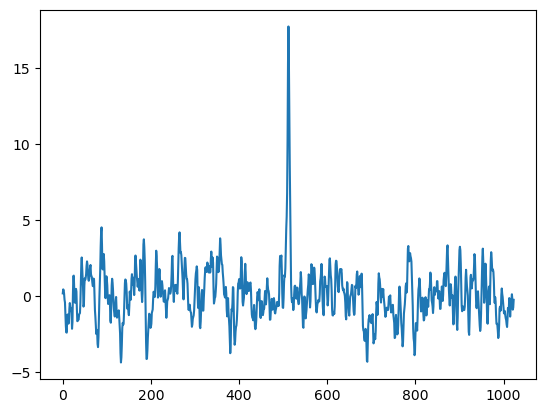

In [319]:

def mc_fitting_func(noise_sd, apod_hz=0):
    FIDs, header = syntheticFID(
        noisecovariance=[[(noise_sd/np.sqrt(2))**2]],
        chemicalshift=chemical_shifts,
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[5, 5],
        amplitude=[10, 10]
    )

    if apod_hz > 0:
        FID, wind = apodise_w(
            FIDs[0],
            1 / bandwidth,
            apod_hz)

        dir_cov = make_windowed_cov(
            wind,
            noise_sd)

    else:
        FID = FIDs[0]
    
    x0 = np.asarray([10, 0, (2+apod_hz)*np.pi])
    fitlsq = fit(FID, x0)
    fitcov = fit_nonlinear_complex_with_bounds(
        FIDToSpec(FID),
        fwd,
        x0,
        dir_cov,
        jac=jac
    )

    return fitlsq[0], fitcov[0], FID

accumulated_param = []
accumulated_param2 = []
n_mc_reps = 2000
noise_vec = [0.01, 0.1, 1, 10]
apod_vec = [1E-15, 0.5, 1, 5, 10, 15, 20]
noise_grid, apod_grid, _ = np.meshgrid(
    noise_vec,
    apod_vec,
    np.arange(n_mc_reps)
)

for idx, (noise, apod) in enumerate(zip(noise_grid.ravel(), apod_grid.ravel())):
    param, param2, example_fid = mc_fitting_func(noise, apod_hz=apod)
    accumulated_param.append(param)
    accumulated_param2.append(param2)
    if not idx % 1000:
        print(f'{idx}/{noise_grid.size}')
plt.plot(FIDToSpec(example_fid).real)


In [374]:
res_lsq = np.asarray(accumulated_param).reshape(apod_grid.shape)
res_mle = np.asarray(accumulated_param2).reshape(apod_grid.shape)

In [384]:
rmse_mle = np.linalg.norm(res_mle-10, axis=-1)/np.sqrt(res_mle.shape[-1])
rmse_lsq = np.linalg.norm(res_lsq-10, axis=-1)/np.sqrt(res_mle.shape[-1])
# As percentage of a peak with conc = 10
rmse_mle *= 100/10
rmse_lsq *= 100/10

Text(0.5, 0.98, 'Mean concentration bias')

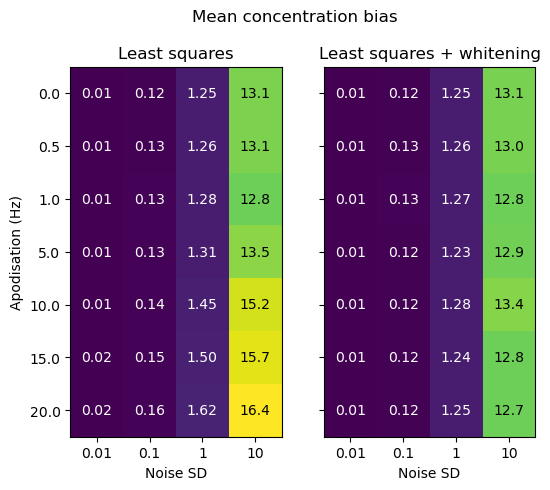

In [402]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5), sharey=True)
ax1.imshow(rmse_lsq, vmin=0, vmax=rmse_lsq.max())
ax2.imshow(rmse_mle, vmin=0, vmax=rmse_lsq.max())


import math

def format_fixed_digits(x, total_digits):
    if x == 0:
        int_digits = 1
    else:
        int_digits = int(math.floor(math.log10(abs(x)))) + 1 if abs(x) >= 1 else 1

    decimals = max(0, total_digits - int_digits)
    return f"{x:.{decimals}f}"

for ax in (ax1, ax2):
    ax.set_xticks(range(len(noise_vec)), labels=noise_vec)
    ax.set_yticks(range(len(apod_vec)), labels=np.round(apod_vec,1))

for idx, _ in enumerate(noise_vec):
    for jdx, _ in enumerate(apod_vec):
        colour = 'k' if rmse_lsq[jdx, idx] >= 5 else 'w'
        text = ax1.text(idx, jdx, format_fixed_digits(rmse_lsq[jdx, idx],3),
                       ha="center", va="center", color=colour)
        colour = 'k' if rmse_mle[jdx, idx] >= 5 else 'w'
        text = ax2.text(idx, jdx,format_fixed_digits(rmse_mle[jdx, idx],3),
                       ha="center", va="center", color=colour)

ax1.set_title('Least squares')
ax2.set_title('Least squares + whitening')
ax1.set_ylabel('Apodisation (Hz)')
ax1.set_xlabel('Noise SD')
ax2.set_xlabel('Noise SD')
fig.suptitle('Mean concentration bias')